In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lstm-training-datasets/train_dataset.csv
/kaggle/input/lstm-training-datasets/test_dataset.csv
/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [2]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed
import warnings
warnings.filterwarnings('ignore')

2022-12-16 16:47:41.363362: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-16 16:47:41.363474: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
!pip install rouge

In [4]:
!pip install -q contractions==0.0.48

In [5]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [6]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-12-16 16:48:01.116800: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-16 16:48:01.119767: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-16 16:48:01.119806: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-16 16:48:01.119868: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6d149e4ed92e): /proc/driver/nvidia/version does not exist
2022-12-16 16:48:01.123885: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

## 🪂 Getting the data

In [7]:
train_dataset_src ='../input/lstm-training-datasets/train_dataset.csv'
test_dataset_src ='../input/lstm-training-datasets/test_dataset.csv'

train_dataset = pd.read_csv(train_dataset_src, encoding='iso-8859-1').reset_index(drop=True)
test_dataset = pd.read_csv(test_dataset_src, encoding='iso-8859-1').reset_index(drop=True)

In [8]:
train_dataset.head(5)

,text,headlines
0,As many as 10 people died after 3 boats capsiz...,10 dead after 3 boats capsize during storm in ...
1,Delhi Daredevils' player Chris Morris recorded...,DD's Morris records 4th highest T20 innings st...
2,"Fox News' parent company, 21st Century Fox, ha...",Fox spent ÃÂ¢ÃÂÃÂ¹290 crore on sexual hara...
3,PM Narendra Modi on Monday started off on his ...,Narendra Modi to visit 4 countries in 6 days
4,Delhi CM Arvind Kejriwal has directed official...,Delhi government plans home delivery from rati...


In [9]:
test_dataset.head()

,text,headlines
0,Qualcomm on Monday announced it won a Chinese ...,Qualcomm wins import ban against Apple's iPhon...
1,The Congress has appointed 42-year-old Amit Ch...,Congress appoints 42-yr-old Amit Chavda as new...
2,"A male nurse, employed at Delhi's Institute of...",Nurse sells stents worth ÃÂ¢ÃÂÃÂ¹90K stole...
3,Finance Minister Arun Jaitley has announced th...,Govt announces Aadhaar-like unique ID for busi...
4,UN's International Organization for Migration ...,UN slams Facebook for failing to tackle human ...


### Baseline Model

In [10]:
import nltk

def tokeniser(t):
    return nltk.sent_tokenize(t)

def word_frequency(many_sent):
    word_frequencies = {}
    for sentence in many_sent:
      words = nltk.word_tokenize(sentence)
      for word in words:
        if word not in word_frequencies.keys():
          word_frequencies[word] = 1
        else:
          word_frequencies[word] += 1
    return word_frequencies
   

def summarize_text(text, count_sent):
    # Tokenizing the text into sentences
    sentences = tokeniser(text)
    
    # Check if the number of sentences requested is valid
    if count_sent > len(sentences):
      return "ERROR: The text does not have that many sentences."

    # Compute the word frequencies    
    word_frequencies=word_frequency(sentences)
    
        
    # Compute the maximum word frequency
    maximum_frequency = max(word_frequencies.values())
    
    # Compute the weighted frequencies
    for word in word_frequencies.keys():
      word_frequencies[word] = (word_frequencies[word]/maximum_frequency)
    
    # Compute the sentence scores
    sentence_scores = {}
    for sentence in sentences:
      words = nltk.word_tokenize(sentence)
      score = 0
      for word in words:
        if word in word_frequencies.keys():
          score += word_frequencies[word]
      sentence_scores[sentence] = score
    
    # Get the top N sentences with the highest scores
    summary_sentences = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)[:count_sent]
    
    # Sort the sentences in the original order
    summary_sentences.sort(key=lambda x: sentences.index(x[0]))
    
    # Generate the summary
    summary = " ".join([x[0] for x in summary_sentences])
    return summary

In [11]:
test_dataset.columns

Index(['text', 'headlines'], dtype='object')

In [12]:
predicted=[]
for each_text in test_dataset['text']:
    predicted.append(summarize_text(each_text, 1))
    
test_dataset['predicted_summary']=predicted

In [13]:
from rouge import Rouge
rouge = Rouge()    
scores = rouge.get_scores(test_dataset['predicted_summary'], test_dataset['headlines'], avg=True)    
#scores = rouge.get_scores(news_df_short['predicted_summary'], news_df_short['headlines'], avg=True)    
scores

{'rouge-1': {'r': 0.4126755674880669,
  'p': 0.15845062869497614,
  'f': 0.2268268512167258},
 'rouge-2': {'r': 0.14671668054168063,
  'p': 0.04937813815105488,
  'f': 0.07316889061210854},
 'rouge-l': {'r': 0.35482922355422253,
  'p': 0.13662368089586172,
  'f': 0.19540098039679182}}

In [14]:
#test_dataset.columns
test_dataset=test_dataset.drop(['predicted_summary'], axis='columns')

The `headlines` column will be treated as `summary` for the text.

## 🏂 Data preparation

In [15]:
def expand_contractions(text, contraction_map=contractions_dict):
    con_key = '|'.join(contraction_map.keys())
    cppp = re.compile(f'({con_key})', flags=re.DOTALL)

    def e_m(contraction):
        match = contraction.group(0)
        exp_c = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return exp_c

    text_e = cppp.sub(e_m, text)
    text_e = re.sub("'", "", text_e)
    return text_e

In [16]:
# # Converting to lowercase
# df.text = df.text.apply(str.lower)
# df.headlines = df.headlines.apply(str.lower)
# df.sample(5)

In [17]:
# Converting to lowercase
train_dataset.text = train_dataset.text.apply(str.lower)
train_dataset.headlines = train_dataset.headlines.apply(str.lower)
train_dataset.sample(5)

,text,headlines
36590,stanford researchers have for the first time c...,scientists find how extraterrestrial ice forms...
65768,the delhi high court on friday pulled up delhi...,why has rape accused daati maharaj not been ar...
95446,a man from west bengal has been arrested by mu...,man arrested for stalking sachin tendulkar's d...
68641,union minister uma bharti on wednesday claimed...,nehru sought help from rss when pak attacked j...
25215,"as two democracies sharing common values, the ...",sky is the limit for india-us ties: us envoy


In [18]:
# Converting to lowercase
test_dataset.text = test_dataset.text.apply(str.lower)
test_dataset.headlines = test_dataset.headlines.apply(str.lower)
test_dataset.sample(5)

,text,headlines
416,the official twitter handle of mumbai police h...,mumbai police uses ariana grande song to promo...
1225,a bihar court has issued an arrest warrant aga...,arrest warrant issued against ex-bihar ministe...
1452,media conglomerate zee entertainment has acqui...,"zee entertainment acquires 9x media, inx music..."
1401,british actor michael sheen said he broke up w...,actor blames brexit for breakup with girlfriend
1165,"swara bhasker, on being asked what makes her d...",ready to voice disappointment if i find someth...


In [19]:
train_dataset.headlines = train_dataset.headlines.apply(expand_contractions)
train_dataset.text = train_dataset.text.apply(expand_contractions)
train_dataset.sample(5)

,text,headlines
23133,a new song titled kar har maidaan fateh from r...,kar har maidaan fateh song from ranbir starrer...
16577,actor salman khan shared a poster of his upcom...,salman khan shares new poster of race 3
2482,the us has returned a 525-year-old copy of a l...,us returns 525-yr-old christopher columbus let...
761,a rabbit named bini holds the guinness world r...,bini the rabbit has guinness record for dunkin...
9056,as much as ãâ¢ãâãâ¹1.17 crore was spent on...,ãâ¢ãâãâ¹1.17cr spent on food during jayas ...


In [20]:
test_dataset.headlines = test_dataset.headlines.apply(expand_contractions)
test_dataset.text = test_dataset.text.apply(expand_contractions)
test_dataset.sample(5)

,text,headlines
1621,shah rukh khan on monday celebrated ashtami wi...,"shah rukh celebrates ashtami with son abram, w..."
1055,former australian wicketkeeper-batsman adam gi...,why did gilchrist bat with squash ball in glov...
1198,worlds most expensive footballer neyhas said f...,"ronaldo is a genius, will change italian footb..."
332,telangana chief minister k chandrashekar rao o...,telangana cm orders formation of 2 new districts
456,after investigating the communal riots that ha...,human rights body blames wb govt for ram navam...


In [21]:
# Remove puncuation from word
def rm_punc_from_word(word):
    good_a=[]
    for alphabet in word:
        if alphabet not in string.punctuation:
            good_a.append(alphabet)
    return ''.join(good_a)
# Remove puncuation from text
def rm_punc_from_text(text):
    goow_w_l=[]
    for word in text:
        goow_w_l.append(rm_punc_from_word(word))
    return ''.join(goow_w_l)

In [22]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

In [23]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list=[]
    for word in text:
        if word not in _stopwords:
            word_list.append(word) 
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [24]:
# Cleaning text
def clean_text(item_in):
    item_in = item_in.lower()
    item_in = rm_punc_from_text(item_in)
    item_in = rm_number_from_text(item_in)
    item_in = rm_stopwords_from_text(item_in)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    item_in = re.sub('–', '', item_in)
    item_in = ' '.join(item_in.split())  # removing `extra` white spaces

    # Removing unnecessary characters from item_in
    item_in = re.sub("(\\t)", ' ', str(item_in)).lower()
    item_in = re.sub("(\\r)", ' ', str(item_in)).lower()
    item_in = re.sub("(\\n)", ' ', str(item_in)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented item_in')
    item_in = unicodedata.normalize('NFKD', item_in).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    item_in = re.sub("(__+)", ' ', str(item_in)).lower()
    item_in = re.sub("(--+)", ' ', str(item_in)).lower()
    item_in = re.sub("(~~+)", ' ', str(item_in)).lower()
    item_in = re.sub("(\+\++)", ' ', str(item_in)).lower()
    item_in = re.sub("(\.\.+)", ' ', str(item_in)).lower()

    item_in = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(item_in)).lower()

    item_in = re.sub("(mailto:)", ' ', str(item_in)).lower()
    item_in = re.sub(r"(\\x9\d)", ' ', str(item_in)).lower()
    item_in = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(item_in)).lower()
    item_in = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(item_in)).lower()

    item_in = re.sub("(\.\s+)", ' ', str(item_in)).lower()
    item_in = re.sub("(\-\s+)", ' ', str(item_in)).lower()
    item_in = re.sub("(\:\s+)", ' ', str(item_in)).lower()
    item_in = re.sub("(\s+.\s+)", ' ', str(item_in)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(item_in))
        repl_url = url.group(3)
        item_in = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(item_in))
    except Exception as e:
        pass

    item_in = re.sub("(\s+)", ' ', str(item_in)).lower()
    item_in = re.sub("(\s+.\s+)", ' ', str(item_in)).lower()

    return item_in

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [25]:
train_dataset.text = train_dataset.text.apply(clean_text)
train_dataset.headlines = train_dataset.headlines.apply(clean_text)
train_dataset.sample(5)

,text,headlines
85104,according reports former infosys ceo vishal si...,sikka might stayed board supported sooner reports
38897,pankaj kapoor talking shahid kapoors newborn s...,zain beautiful name pankaj kapoor grandson
13589,actress bhumi pednekar talking relationship st...,think lust life love life bhumi
22439,convicted killer run last three years recently...,killer run yrs gets hair transplant new look a...
16729,former hindustan unilever hul chairman thomas ...,former hul chairman thomas passes away aged


In [26]:
test_dataset.text = test_dataset.text.apply(clean_text)
test_dataset.headlines = test_dataset.headlines.apply(clean_text)
test_dataset.sample(5)

,text,headlines
1442,big bazaar owner future groups ceo kishore biy...,stupid online space future group ceo biyani
441,union minister ravi shankar prasad said artifi...,ai used governance improvthement minister
791,locals broken vandalised around fire hydrants ...,french locals break fire hydrants amid record ...
1739,pakistans newlyappointed foreign minister shah...,takes two tango pak foreign minister ties india
1052,bengalurubased cab aggregator ola raised billi...,ola raises largest funding round billion


In [27]:
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)

Using a `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

In [28]:
train_dataset.headlines = train_dataset.headlines.apply(lambda x: f'_START_ {x} _END_')
test_dataset.headlines = test_dataset.headlines.apply(lambda x: f'_START_ {x} _END_')

Again adding `tokens` ... but different ones.

In [29]:
start_token = 'sostok'
end_token = 'eostok'

train_dataset.headlines = train_dataset.headlines.apply(lambda x: f'{start_token} {x} {end_token}')
test_dataset.headlines = test_dataset.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

It's important to use `sostok` and `eostok` as start and end tokens respectively as later while using `tensorflow's Tokenizer` will filter the tokens and covert them to lowercase.

**sostok** & **eostok** tokens are for us to know where to start & stop the summary because using `_START_` & `_END_`, tf's tokenizer with convert them to **start** & **end** respectively.

So while decoding the summary sequences of sentences like **'everything is going to end in 2012'** if use `_START_` & `_END_` tokens (which will make the sentence like **'start everything is going to end in 2012 end'** this) whome tf's tokenizer will convert to start and end then we will stop decoding as we hit first **end**, so this is bad and therefore **sostok** & **eostok** these tokens are used.

So we can just use these **sostok** & **eostok** instead of `_START_` & `_END_`, well you can but I tried both ways and while not using these `_START_` & `_END_` I was getting `undesired results` 🤯 😅 i.e. model's `results weren't good`.

In [30]:
train_dataset.sample(5)

,text,headlines
16958,madras high court dismissed petitions burials ...,sostok _START_ karunanidhi buried na beach mad...
84149,punjab state aids control society psacs publis...,sostok _START_ aids spreads via handshake says...
31249,britains exit european union without deal woul...,sostok _START_ brexit without deal would end w...
5825,airasia india carried million passengers mber ...,sostok _START_ airasia india passengers volume...
65808,usbased ridehailing startup uber said talks bu...,sostok _START_ uber may buy billiondollar food...


Finding what should be the `maximum length` of text and headlines that will be feed or accepted by the learning algorithm.

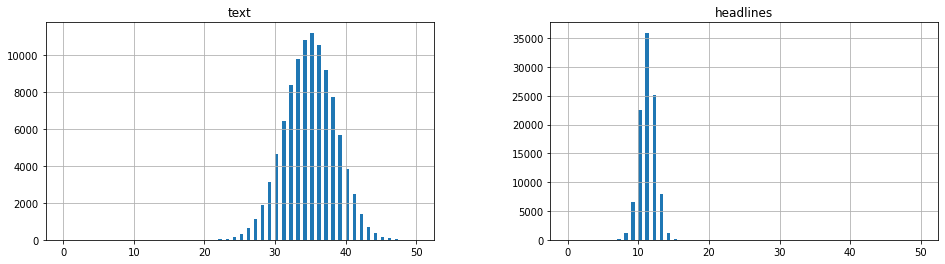

In [31]:
text_count = [len(sentence.split()) for sentence in train_dataset.text]
headlines_count = [len(sentence.split()) for sentence in train_dataset.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [32]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(train_dataset.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(train_dataset.text, 42))

0.99
0.99


If the length of headlines or the text is kept large the deep learning model will face issues with performance and also training will slower.

One solution for creating summary for long sentences can be break a paragraph into sentences and then create a summary for them, this way the summary will make sence instead of giving random piece of text and creating summary for it.

In [33]:
max_text_len = 42
max_summary_len = 13

In [34]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    ctt = np.array(df['text'])
    c_sum = np.array(df['headlines'])

    short_t = []
    s_short = []

    for i in range(len(ctt)):
        if len(ctt[i].split()) <= max_text_len and len(
            c_sum[i].split()
        ) <= max_summary_len:
            short_t.append(ctt[i])
            s_short.append(c_sum[i])

    df = pd.DataFrame({'text': short_t, 'summary': s_short})
    return df

In [35]:
train_dataset = trim_text_and_summary(train_dataset, max_text_len, max_summary_len)
print(f'Dataset size: {len(train_dataset)}')
train_dataset.sample(5)

Dataset size: 98307


,text,summary
10561,slamming government unnao kathua rape cases le...,sostok _START_ kathua unnao cases darkest hour...
95580,former cia director john brennan threatened le...,sostok _START_ excia chief threatens sue trump...
86339,india defeated australia runs adelaide test mo...,sostok _START_ india win opening match test se...
34126,rbi soon put circulation new notes one rupee d...,sostok _START_ rbi put new rupee notes circula...
13533,israel established apartheid regime racial dis...,sostok _START_ israel imposes apartheid regime...


In [36]:
test_dataset = trim_text_and_summary(test_dataset, max_text_len, max_summary_len)
print(f'Dataset size: {len(test_dataset)}')
test_dataset.sample(5)

Dataset size: 1949


,text,summary
192,fiveminute bell located outside bowlers bar lo...,sostok _START_ significance fiveminute bell lo...
273,budget carrier spicejets stock surged year mak...,sostok _START_ spicejet worlds top airline sto...
1702,chhattisgarh recorded voter turnout till pm se...,sostok _START_ voting nd phase polls till pm c...
1643,delhibased garment retailer people tree accuse...,sostok _START_ delhibased brand accuses dior p...
847,economic affairs secretary subhash chandra gar...,sostok _START_ govt disappointed sp rating eco...


In [37]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    nums = 0
    num_final = 0
    fqy = 0
    fqy_tot = 0

    for key, value in tokenizer.word_counts.items():
        num_final += 1
        fqy_tot += value
        if value < threshold:
            nums += 1
            fqy += value

    return {
        'percent': round((nums / num_final) * 100, 2),
        'total_coverage': round(fqy / fqy_tot * 100, 2),
        'nums': nums,
        'num_final': num_final
    }

In [38]:
test_dataset.head()

,text,summary
0,qualcomm monday announced chinese court order ...,sostok _START_ qualcomm wins import ban apples...
1,congress appointed yearold amit chavda new chi...,sostok _START_ congress appoints yrold amit ch...
2,male nurse themployed delhis institute liver b...,sostok _START_ nurse sells stents worth aaaaaa...
3,finance minister arun jaitley announced govern...,sostok _START_ govt announces aadhaarlike uniq...
4,uns international organization migration iom s...,sostok _START_ un slams facebook failing tackl...


In [39]:
x_train=np.array(train_dataset['text'])
x_val=np.array(test_dataset['text'])
y_train=np.array(train_dataset['summary'])
y_val=np.array(test_dataset['summary'])

In [40]:
print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))

98307
1949
98307
1949


**Tokenizing text 👉 x**

In [41]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.39, 'total_coverage': 2.83, 'nums': 68094, 'num_final': 104137}


In [42]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [43]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

104138


In [45]:
print(len(x_train_sequence))
print(len(x_val_sequence))
print(len(x_train_padded))
print(len(x_val_padded))

98307
1949
98307
1949


**Tokenizing headlines(summary) 👉 y**

In [46]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 68.85, 'total_coverage': 4.54, 'nums': 26705, 'num_final': 38786}


In [47]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [48]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

38787


In [50]:
print(len(y_train_sequence))
print(len(y_val_sequence))
print(len(y_train_padded))
print(len(y_val_padded))

98307
1949
98307
1949


In [51]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

In [52]:
print(len(y_val_padded))
print(len(x_val_padded))

1949
1949


# Build Models

In [53]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

In [56]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = '../input/glove6b/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)


Found 400000 word vectors.
Converted 56744 words (47393 misses)
Found 400000 word vectors.
Converted 27774 words (11012 misses)


In [57]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(104138, 300)
(38787, 300)


In [58]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    with tpu_strategy.scope():
        #Encoder
        encoder_input = Input(shape=(max_text_len, ))

        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)


        #Decoder
        decoder_input = Input(shape=(None, ))
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        #Model
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [59]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 300)      31241400    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 240), (N 519360      embedding[0][0]                  
______________________________________________________________________________________________

In [60]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [61]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [62]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

In [63]:
len(x_train_padded)

98307

In [64]:
len(y_train_padded[:, :-1])

98307

In [65]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
97/97 [==============================] - 37s 212ms/step - loss: 6.9375 - accuracy: 0.2534 - val_loss: 5.0674 - val_accuracy: 0.4313
Epoch 2/50
97/97 [==============================] - 5s 48ms/step - loss: 5.1784 - accuracy: 0.4188 - val_loss: 4.8964 - val_accuracy: 0.4359
Epoch 3/50
97/97 [==============================] - 5s 49ms/step - loss: 5.0107 - accuracy: 0.4230 - val_loss: 4.6496 - val_accuracy: 0.4442
Epoch 4/50
97/97 [==============================] - 5s 48ms/step - loss: 4.7192 - accuracy: 0.4311 - val_loss: 4.4024 - val_accuracy: 0.4504
Epoch 5/50
97/97 [==============================] - 5s 48ms/step - loss: 4.4551 - accuracy: 0.4390 - val_loss: 4.2631 - val_accuracy: 0.4540
Epoch 6/50
97/97 [==============================] - 5s 49ms/step - loss: 4.2599 - accuracy: 0.4462 - val_loss: 4.0983 - val_accuracy: 0.4632
Epoch 7/50
97/97 [==============================] - 5s 48ms/step - loss: 4.0896 - accuracy: 0.4532 - val_loss: 3.9699 - val_accuracy: 0.4699
Epoch 8/50


Inference

In [66]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [67]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    decoder_embedding = decoder_embedding_layer(decoder_input)
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    decoder_output = decoder_dense(decoder_output)

    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [68]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [69]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 42, 300)           31241400  
_________________________________________________________________
lstm (LSTM)                  [(None, 42, 240), (None,  519360    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 42, 240), (None,  461760    
Total params: 32,222,520
Trainable params: 981,120
Non-trainable params: 31,241,400
_________________________________________________________________


In [70]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    11636100    input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 240)]        0                                            
____________________________________________________________________________________________

In [71]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

Converting from `sequence to text` for model `with just LSTM's` and for model `with Bidirectional LSTM's`.

In [72]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    target_seq = np.zeros((1, 1))

    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [73]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [74]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [75]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
    

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

# Predict

In [76]:
#len(y_val_padded)
len(x_val_padded)

1949

In [77]:
from tqdm import tqdm
val_set_len=len(x_val_padded)
original_sum=[]
predicted_ans=[]
for i in tqdm(range(val_set_len)):
    original_sum.append(seq2summary(y_val_padded[i]))
    predicted_ans.append(decode_sequence_seq2seq_model_with_just_lstm(x_val_padded[i].reshape(1, max_text_len), encoder_model,decoder_model))
    
# f1 = lambda x: seq2summary(y_val_padded[x])  
# original_sum = [f1(i) for i in range(val_set_len)]


100%|██████████| 1949/1949 [25:31<00:00,  1.27it/s]


In [78]:
# from tqdm import tqdm
# f2 = lambda x: decode_sequence_seq2seq_model_with_just_lstm(x_val_padded[i].reshape(1, max_text_len), encoder_model,decoder_model)  
# predicted_ans = [f2(i) for i in tqdm(range(val_set_len))]

In [79]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  qualcomm monday announced chinese court order banning import sale appleaaaaaas iphone iphone models china due software patent violations court found apple violated two software patents around photographs managing applications touchscreen apple however said iphones rthemain sale china 
Original summary:  start qualcomm wins import ban apples iphones china end 
Predicted summary:   start apple ban huawei patent dispute china end

# 2 News:  congress appointed yearold amit chavda new chief gujarat unit replacing yearold bharatsinh solanki held post since mber comes days congress president rahul gandhi said younger generations come forward take party leadership inspired gandhis words yearold shantaram naik resigned goa congress chief 
Original summary:  start congress appoints yrold amit new gujarat head end 
Predicted summary:   start gujarat congress appoints first fthemale chief congress end

# 3 News:  male nurse themployed delhis institute liver biliary sciences booked alle

In [80]:
print(len(original_sum),len(predicted_ans))

1949 1949


In [81]:
from rouge import Rouge
rouge = Rouge()    
scores = rouge.get_scores(predicted_ans, original_sum, avg=True)    
scores

{'rouge-1': {'r': 0.40783853709713175,
  'p': 0.4643238068584406,
  'f': 0.43021006946958035},
 'rouge-2': {'r': 0.08353836318177012,
  'p': 0.08969867997574495,
  'f': 0.08587719554325225},
 'rouge-l': {'r': 0.3949093108020768,
  'p': 0.4496676617379551,
  'f': 0.41656289325070284}}